# 0.0. IMPORTS

In [ ]:
!pip install xgboost
!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 3.7 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 28.6 MB/s eta 0:00:00
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import pandas            as pd
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import xgboost           as xgb
import lightgbm          as lgb

import random

#from pycorrcat import pycorrcat

from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.linear_model  import LinearRegression, Lasso

from sklearn               import model_selection   as ms
from sklearn               import ensemble          as en

## 0.1. Aux Functions

In [ ]:
def settings():
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25,12]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    sns.set()


def ml_error( model_name, ytest, yhat ):
    mae = mean_absolute_error( ytest, yhat )
    mape = mean_absolute_percentage_error( ytest, yhat )
    rmse = np.sqrt( mean_squared_error( ytest, yhat ) )
    
    return pd.DataFrame( {'Model name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0] )

def analise_bivariada(df,column):
    plt.figure(figsize=(15,10))
    aux1=df[[column,'preco']].groupby(column).mean().reset_index()
    plt.subplot(2,1,1)
    sns.barplot(x=column,y='preco',data=aux1)
    plt.title('Mean')
    
    aux2=df[[column,'preco']].groupby(column).median().reset_index()
    plt.subplot(2,1,2)
    sns.barplot(x=column,y='preco',data=aux2)
    plt.title('Median')

## 0.2. Reading Data

In [ ]:
df_raw=pd.read_csv('/work/treino.csv')
df_test=pd.read_csv('/work/teste.csv')

# 1.0. DESCRIÇÃO DOS DADOS

In [ ]:
df1=df_raw.copy()
df1.columns=['id', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_unico_dono',
       'attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fabrica',
       'attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado', 'preco']

## 1.1. Dimensão dos Dados

In [ ]:
df1.shape

(39446, 29)

## 1.2. NA Check

In [ ]:
df1.isna().sum()

id                                                                0
num_fotos                                                       237
marca                                                             0
modelo                                                            0
versao                                                            0
ano_de_fabricacao                                                 0
ano_modelo                                                        0
odometro                                                          0
cambio                                                            0
num_portas                                                        0
tipo                                                              0
blindado                                                          0
cor                                                               0
tipo_vendedor                                                     0
cidade_vendedor                                 

### 1.2.1. Fillout NA

In [ ]:
df1['num_fotos']=df1['num_fotos'].fillna(0)
df1['attr_veiculo_aceita_troca'] = df1['attr_veiculo_aceita_troca'].apply(lambda x: 1 if x=='Aceita troca' else 0)
df1['attr_veiculo_unico_dono'] = df1['attr_veiculo_unico_dono'].apply(lambda x: 1 if x=='Único dono' else 0)
df1['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'] = df1['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'].apply(lambda x: 1 if x=='Todas as revisões feitas pela concessionária' else 0)
df1['attr_veiculo_ipva_pago'] = df1['attr_veiculo_ipva_pago'].apply(lambda x: 1 if x=='IPVA pago' else 0)
df1['attr_veiculo_licenciado'] = df1['attr_veiculo_licenciado'].apply(lambda x: 1 if x=='Licenciado' else 0)
df1['attr_veiculo_garantia_de_fabrica'] = df1['attr_veiculo_garantia_de_fabrica'].apply(lambda x: 1 if x=='Garantia de fábrica' else 0)
df1['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro'] = df1['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro'].apply(lambda x: 1 if x=='Todas as revisões feitas pela agenda do carro' else 0)

## 1.3. Tipos dos Dados

In [ ]:
df1.dtypes

id                                                             object
num_fotos                                                     float64
marca                                                          object
modelo                                                         object
versao                                                         object
ano_de_fabricacao                                               int64
ano_modelo                                                    float64
odometro                                                      float64
cambio                                                         object
num_portas                                                      int64
tipo                                                           object
blindado                                                       object
cor                                                            object
tipo_vendedor                                                  object
cidade_vendedor     

### 1.3.1. Change data types

In [ ]:
df1['num_fotos']=df1['num_fotos'].astype('int64')
df1['ano_modelo']=df1['ano_modelo'].astype('int64')
df1['odometro']=df1['odometro'].astype('int64')
df1['attr_veiculo_aceita_troca']=df1['attr_veiculo_aceita_troca'].astype('int64')
df1['attr_veiculo_unico_dono']=df1['attr_veiculo_unico_dono'].astype('int64')
df1['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria']=df1['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'].astype('int64')
df1['attr_veiculo_ipva_pago']=df1['attr_veiculo_ipva_pago'].astype('int64')
df1['attr_veiculo_licenciado']=df1['attr_veiculo_licenciado'].astype('int64')
df1['attr_veiculo_garantia_de_fabrica']=df1['attr_veiculo_garantia_de_fabrica'].astype('int64')
df1['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro']=df1['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro'].astype('int64')
df1['attr_veiculo_alienado']=df1['attr_veiculo_alienado'].astype(str)

## 1.4. Estatística Descritiva

In [ ]:
num_attr=df1.select_dtypes(include=['int64','float64'])
cat_attr=df1.select_dtypes(exclude=['int64','float64'])

In [ ]:
cat_attr.columns

Index(['id', 'marca', 'modelo', 'versao', 'cambio', 'tipo', 'blindado', 'cor',
       'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor', 'tipo_anuncio',
       'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_alienado'],
      dtype='object')

### 1.4.1 Atributos Numéricos

In [ ]:
# Central Tendency - mean, median
ct1=pd.DataFrame(num_attr.apply(np.mean)).T
ct2=pd.DataFrame(num_attr.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1=pd.DataFrame(num_attr.apply(np.std)).T
d2=pd.DataFrame(num_attr.apply(min)).T
d3=pd.DataFrame(num_attr.apply(max)).T
d4=pd.DataFrame(num_attr.apply(lambda x: x.max()-x.min())).T
d5=pd.DataFrame(num_attr.apply(lambda x: x.skew())).T
d6=pd.DataFrame(num_attr.apply(lambda x: x.kurtosis())).T

# Concatenate
m=pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns=['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,num_fotos,0.000000,2.100000e+01,2.100000e+01,10.261801,8.000000,3.561070,0.831612,-0.397392
1,ano_de_fabricacao,1985.000000,2.022000e+03,3.700000e+01,2016.748137,2018.000000,4.084710,-2.512826,9.277637
2,ano_modelo,1997.000000,2.023000e+03,2.600000e+01,2017.807154,2018.000000,2.675300,-0.498274,-0.534887
3,odometro,100.000000,3.900650e+05,3.899650e+05,58382.243371,57244.500000,32542.380554,0.606748,1.251382
4,num_portas,2.000000,4.000000e+00,2.000000e+00,3.941135,4.000000,0.337206,-5.568483,29.052409
5,attr_veiculo_aceita_troca,0.000000,1.000000e+00,1.000000e+00,0.741013,1.000000,0.438078,-1.100361,-0.789246
6,attr_veiculo_unico_dono,0.000000,1.000000e+00,1.000000e+00,0.352330,0.000000,0.477696,0.618284,-1.617807
7,attr_veiculo_todas_as_revisoes_feitas_pela_con...,0.000000,1.000000e+00,1.000000e+00,0.310272,0.000000,0.462605,0.820289,-1.327193
8,attr_veiculo_ipva_pago,0.000000,1.000000e+00,1.000000e+00,0.664782,1.000000,0.472067,-0.698158,-1.512652
9,attr_veiculo_licenciado,0.000000,1.000000e+00,1.000000e+00,0.538711,1.000000,0.498499,-0.155317,-1.975977


### 1.4.2. Atributos Categóricos

In [ ]:
cat_attr.apply(lambda x: x.unique().shape[0])

id                       39446
marca                       41
modelo                     473
versao                    2058
cambio                       7
tipo                         8
blindado                     2
cor                          8
tipo_vendedor                2
cidade_vendedor            648
estado_vendedor             25
tipo_anuncio                 4
entrega_delivery             2
troca                        2
elegivel_revisao             1
attr_veiculo_alienado        1
dtype: int64

<AxesSubplot:xlabel='tipo_vendedor', ylabel='preco'>

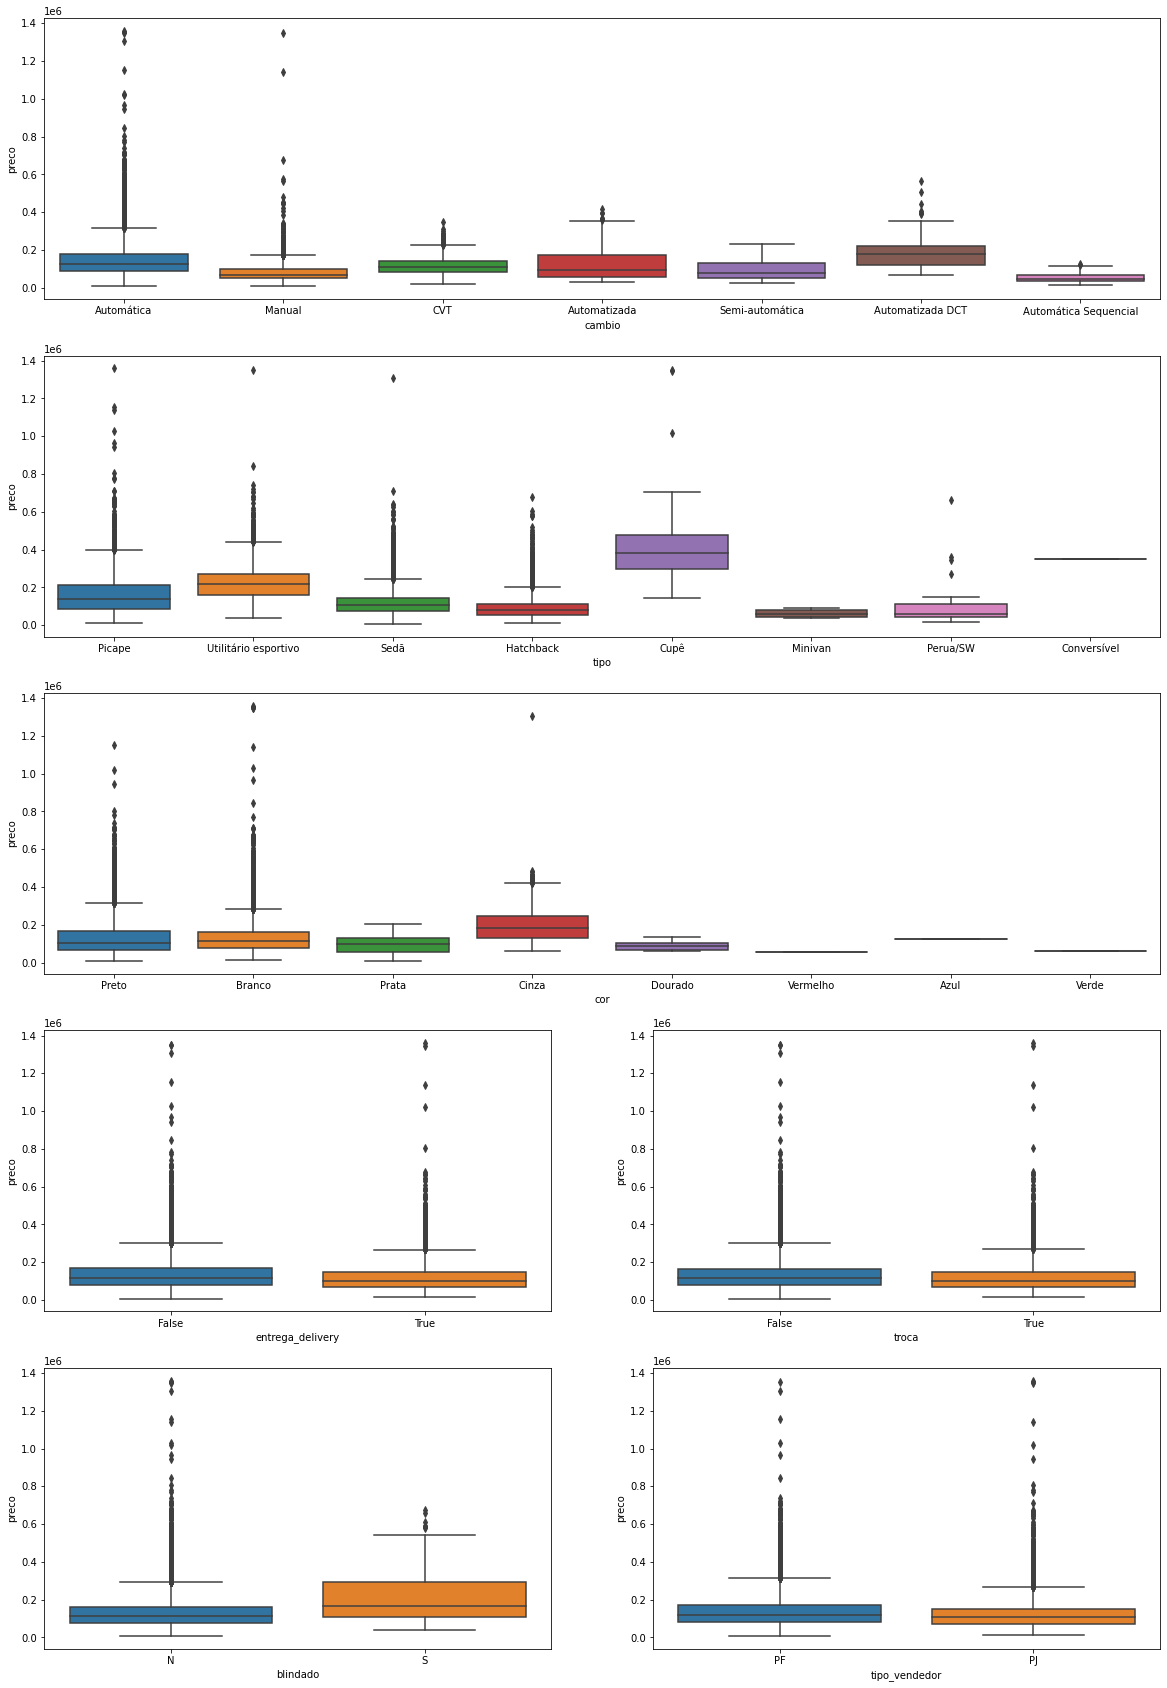

In [ ]:
plt.figure(figsize=(20,30))
plt.subplot(5,2,(1,2))
sns.boxplot(x='cambio',y='preco',data=df1)
plt.subplot(5,2,(3,4))
sns.boxplot(x='tipo',y='preco',data=df1)
plt.subplot(5,2,(5,6))
sns.boxplot(x='cor',y='preco',data=df1)
plt.subplot(5,2,7)
sns.boxplot(x='entrega_delivery',y='preco',data=df1)
plt.subplot(5,2,8)
sns.boxplot(x='troca',y='preco',data=df1)
plt.subplot(5,2,9)
sns.boxplot(x='blindado',y='preco',data=df1)
plt.subplot(5,2,10)
sns.boxplot(x='tipo_vendedor',y='preco',data=df1)

# 2.0. FEATURE ENGINEERING

In [ ]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

## 2.2. Criação de Hipóteses

## 2.3. Lista de Hipóteses

## 2.4. Feature Engineering

In [ ]:
## ano de fabricacao one hot
#bin1 = [1985, 2000]
#bin2 = [2000, 2005]
#bin3 = [2005, 2010]
#bin4 = [2010, 2015]
#bin5 = [2015, 2020]
#bin6 = [2020, 2025]
#bins = [bin1, bin2, bin3, bin4, bin5, bin6]
#
#year_bins = []
#
#for i in range(df2.shape[0]):
#    tmp = [0 for i in range(len(bins))]
#    ye = df2['ano_de_fabricacao'][i]
#    for j in range(len(bins)):
#        if ye >= bins[j][0] and ye < bins[j][1]:
#            tmp[j] = 1
#    year_bins.append(tmp)
#year_bins = np.asarray(year_bins)
#new_df = pd.DataFrame(year_bins, columns=['Year_Bin'+str(i+1) for i in range(len(bins))])
#df2 = pd.concat( [df2, new_df], axis=1 )

# cbin1 = [7000, 20000]
# cbin2 = [20000, 40000]
# cbin3 = [40000, 80000]
# cbin4 = [80000, 100000]
# cbin5 = [100000, 200000]
# cbin6 = [200000, 500000]
# cbin7 = [500000, 1000000]
# cbins = [bin1, bin2, bin3, bin4, bin5, bin7]

# cyear_bins = []

# for i in range(df2.shape[0]):
#     tmp = [0 for i in range(len(cbins))]
#     ye = df2['ano_de_fabricacao'][i]
#     for j in range(len(cbins)):
#         if ye >= cbins[j][0] and ye < cbins[j][1]:
#             tmp[j] = 1
#     year_bins.append(tmp)
# year_bins = np.asarray(cyear_bins)
# new_df = pd.DataFrame(cyear_bins, columns=['Year_Bin'+str(i+1) for i in range(len(cbins))])
# df2 = pd.concat( [df2, new_df], axis=1 )
# df2 = df2.drop(columns=['ano_de_fabricacao'])

# =======================================================================

# ano de fabricação
df2['ano_de_fabricacao_2011']=df2['ano_de_fabricacao'].apply(lambda x: 1 if x>2010 else 0)
# ano_modelo
df2['ano_modelo_2011']=df2['ano_de_fabricacao'].apply(lambda x: 1 if x>2010 else 0)
# kilometragem 100 - 400000
df2['km']=df2['odometro'].apply(lambda x: '0_40000' if x<=40000 else
                                            '40000_80000'if x<=80000 else
                                            '80000_120000' if x<=120000  else
                                            '120000_160000' if x<=160000  else
                                            '160000_200000' if x<=200000  else
                                            '200000_240000' if x<=240000  else
                                            '240000_280000' if x<=280000  else
                                            '280000_320000' if x<=320000  else
                                            '320000_360000' if x<=360000  else
                                            '360000_400000')
# motor
df2['motor_3_chr']=df2['versao'].apply(lambda x: x[0:3])
df2['motor_num']=df2['motor_3_chr'].apply(lambda x: x[0:1].isnumeric())
df2['motor_ponto']=df2['motor_3_chr'].apply(lambda x: x[1:2]=='.')
df2['motor']=df2[['motor_num','motor_ponto','motor_3_chr']].apply(lambda x: x['motor_3_chr'] if (x['motor_num']==True)&(x['motor_ponto']==True) else 0,axis=1)
df2['motor']=df2['motor'].astype('float64')


# 3.0. FILTRAGEM DE VARIÁVEIS

In [ ]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [ ]:
# substituindo ano de fabricacao caso a diferença para o ano modelo seja superior a 1 ano
#df3['dif_ano'] = df3.apply(lambda x: x['ano_modelo'] - x['ano_de_fabricacao'], axis=1)
#df3[df3['dif_ano'] > 1].count()
#
#df3['ano_de_fabricacao'] = df3.apply(lambda x: (x['ano_modelo']-1) if x['dif_ano'] > 1 else x['ano_de_fabricacao'], axis=1)

## 3.2. Seleção das Colunas

In [ ]:
df3 = df3.drop( columns=['elegivel_revisao','attr_veiculo_alienado', 'motor_3_chr', 'motor_num', 'motor_ponto','versao'])

# 4.0. EDA

In [ ]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/shared-libs/python3.9/py/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


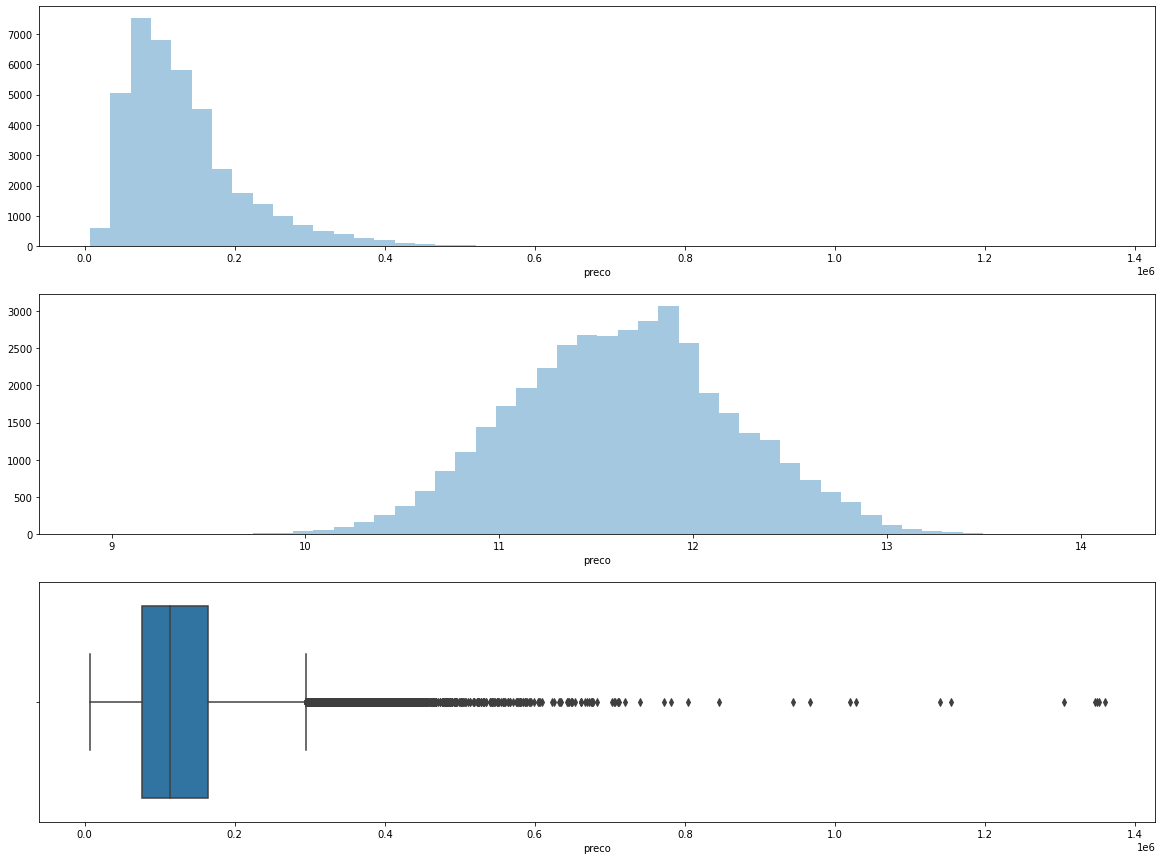

In [ ]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
sns.distplot(df4['preco'], kde=False);
# transformação log
plt.subplot(3,1,2)
sns.distplot(np.log(df4['preco']), kde=False);
plt.subplot(3,1,3)
sns.boxplot(df4['preco']);

### 4.1.1. Numerical Variable

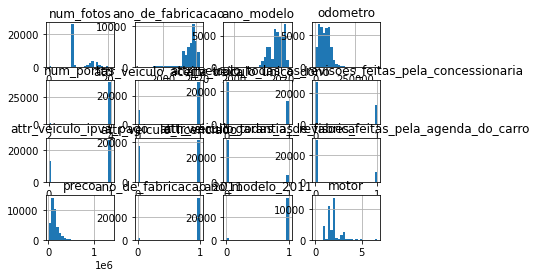

In [ ]:
num_attributes = df4.select_dtypes(include='number')
num_attributes.hist(bins=25);

### 4.1.1Categorical Variable

In [ ]:
cat_attributes = df4.select_dtypes(exclude='number')
cat_attributes.columns

Index(['id', 'marca', 'modelo', 'cambio', 'tipo', 'blindado', 'cor',
       'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor', 'tipo_anuncio',
       'entrega_delivery', 'troca', 'km'],
      dtype='object')

## 4.2. Analise Bivariada

In [ ]:
df4['estado_vendedor'].unique()

array(['São Paulo (SP)', 'Rio Grande do Sul (RS)', 'Minas Gerais (MG)',
       'Paraná (PR)', 'Rio de Janeiro (RJ)', 'Maranhão (MA)',
       'Santa Catarina (SC)', 'Alagoas (AL)', 'Bahia (BA)', 'Goiás (GO)',
       'Rio Grande do Norte (RN)', 'Pernambuco (PE)', 'Mato Grosso (MT)',
       'Pará (PA)', 'Ceará (CE)', 'Amazonas (AM)', 'Espírito Santo (ES)',
       'Rondônia (RO)', 'Paraíba (PB)', 'Tocantins (TO)', 'Acre (AC)',
       'Sergipe (SE)', 'Mato Grosso do Sul (MS)', 'Roraima (RR)',
       'Piauí (PI)'], dtype=object)

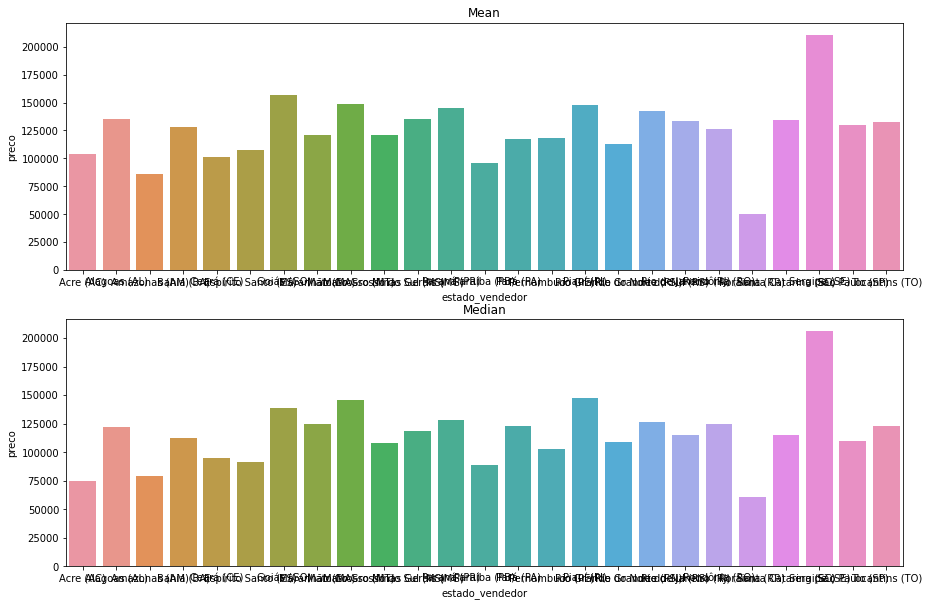

In [ ]:
analise_bivariada(df4,'estado_vendedor')

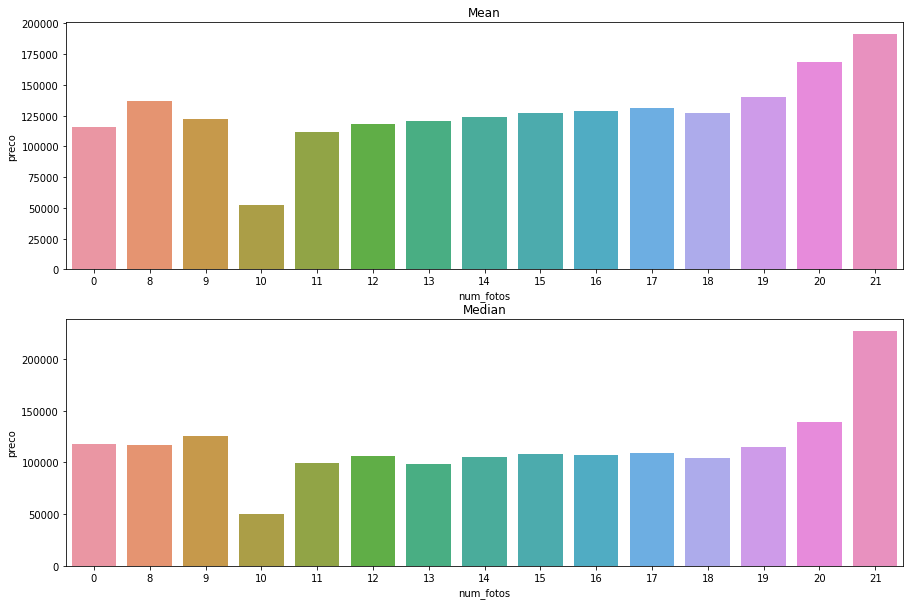

In [ ]:
analise_bivariada(df4,'num_fotos')

## 4.3. Analise Multivariada

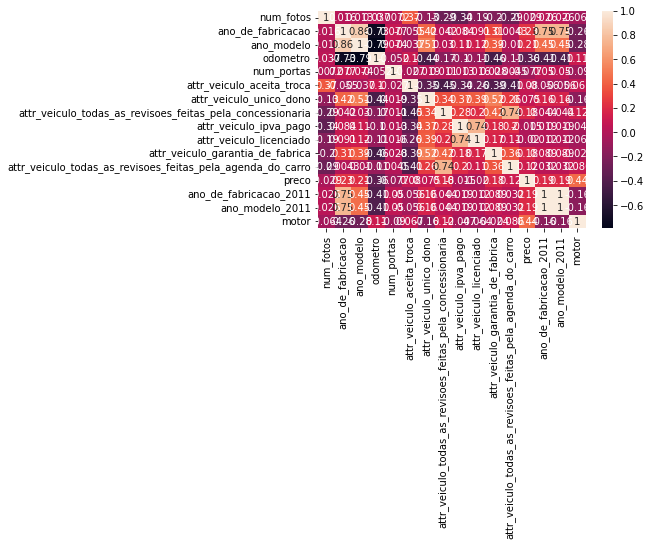

In [ ]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

In [ ]:
#plotcor = pycorrcat.corr_matrix(cat_attributes, ['marca', 'modelo', 'versao', 'cambio', 'tipo', 'blindado', 'cor',
#       'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor', 'tipo_anuncio',
#       'entrega_delivery', 'troca', 'attr_veiculo_aceita_troca',
#       'attr_veiculo_único_dono',
#       'attr_veiculo_todas_as_revisões_feitas_pela_concessionária',
#       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
#       'attr_veiculo_garantia_de_fábrica',
#       'attr_veiculo_todas_as_revisões_feitas_pela_agenda_do_carro'])
#sns.heatmap(plotcor, annot=True);

# 5.0. DATA PREPARATION

In [ ]:
df5 = df4.copy()

## 5.1. Encoding

In [ ]:
# label encoder
# le = LabelEncoder()
#df5['marca'] = le.fit_transform(df5['marca'])
#df5['cor'] = le.fit_transform(df5['cor'])
#df5['tipo'] = le.fit_transform(df5['tipo'])
# ===================================================

#labelencoding
le = LabelEncoder()
df5['modelo'] = le.fit_transform(df5['modelo'])
#df5['km']=le.fit_transform(df5['km'])
df5['blindado'] = df5['blindado'].apply( lambda x: 1 if x == "S" else 0 )
df5['troca'] = df5['troca'].apply( lambda x: 1 if x == True else 0)
df5['entrega_delivery'] = df5['entrega_delivery'].apply( lambda x: 1 if x == True else 0)

# dummies
df5 = pd.get_dummies( df5, columns=['cambio','tipo_vendedor','tipo_anuncio', 'cor','tipo','km'] )

#frequency encoder
fe_modelo = df5.groupby('modelo').size() / len(df5)
df5.loc[:,'modelo'] = df5['modelo'].map(fe_modelo)
fe_marca = df5.groupby('marca').size() / len(df5)
df5.loc[:,'marca'] = df5['marca'].map(fe_marca)
fe_cidade_vendedor = df5.groupby('cidade_vendedor').size() / len(df5)
df5.loc[:,'cidade_vendedor'] = df5['cidade_vendedor'].map(fe_cidade_vendedor)


df4['estado_vendedor']=df4['estado_vendedor'].apply(lambda x: 'SP' if x=='São Paulo (SP)' else 
                                                        'RS' if x=='Rio Grande do Sul (RS)' else 
                                                        'MG' if x=='Minas Gerais (MG)' else
                                                        'PR' if x=='Paraná (PR)' else
                                                        'RJ' if x=='Rio de Janeiro (RJ)' else
                                                        'MA' if x=='Maranhão (MA)' else
                                                        'SC' if x=='Santa Catarina (SC)' else
                                                        'AL' if x=='Alagoas (AL)' else
                                                        'BA' if x=='Bahia (BA)' else
                                                        'GO' if x=='Goiás (GO)' else
                                                        'RN' if x=='Rio Grande do Norte (RN)' else
                                                        'PE' if x=='Pernambuco (PE)' else
                                                        'MT' if x=='Mato Grosso (MT)' else
                                                        'PA' if x=='Pará (PA)' else
                                                        'CE' if x=='Ceará (CE)' else
                                                        'AM' if x=='Amazonas (AM)' else
                                                        'ES' if x=='Espírito Santo (ES)'else
                                                        'RO' if x=='Rondônia (RO)' else
                                                        'PB' if x=='Paraíba (PB)' else
                                                        'TO' if x=='Tocantins (TO)' else
                                                        'AC' if x=='Acre (AC)'else
                                                        'SE' if x=='Sergipe (SE)' else
                                                        'MS' if x=='Mato Grosso do Sul (MS)' else
                                                        'RR' if x=='Roraima (RR)'else
                                                        'PI' if x=='Piauí (PI)' else 0)

fe_estado_vendedor = df5.groupby('estado_vendedor').size() / len(df5)
df5.loc[:,'estado_vendedor'] = df5['estado_vendedor'].map(fe_estado_vendedor)

## 5.2. Normalização

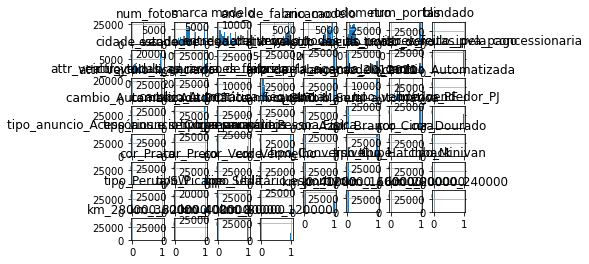

In [ ]:
num_attributes = df5.select_dtypes(include='number')
num_attributes.hist(bins=25);

## 5.3. Rescaling

In [ ]:
rs = RobustScaler()
mms = MinMaxScaler()

df5['num_fotos'] = mms.fit_transform(df5[['num_fotos']].values)
df5['ano_de_fabricacao'] = rs.fit_transform(df5[['ano_de_fabricacao']].values)
df5['ano_modelo'] = rs.fit_transform(df5[['ano_modelo']].values)
df5['odometro'] = rs.fit_transform(df5[['odometro']].values)

## 5.4. Transformação

# 6.0. FEATURE SELECTION

In [ ]:
df6 = df5.copy()

## 6.1. Feature Importancia

In [ ]:
# model
forest = en.ExtraTreesRegressor( n_estimators=250, random_state=0, n_jobs=-1 )

# training
x_train_fselection = df6.drop( ['preco','id'], axis=1 )
y_train_fselection = df6['preco'].values
forest.fit( x_train_fselection, y_train_fselection )

ExtraTreesRegressor(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:

                                             feature    importance
0                                              motor  1.742625e-01
0                          tipo_Utilitário esportivo  1.586660e-01
0                                         km_0_40000  7.168565e-02
0                                             modelo  6.408736e-02
0                                           odometro  5.141209e-02
0                                              marca  4.874724e-02
0                                        tipo_Picape  4.193550e-02
0                                         ano_modelo  4.150827e-02
0                                  ano_de_fabricacao  3.491937e-02
0                                  cambio_Automática  3.030119e-02
0                                      cambio_Manual  2.845438e-02
0                                    cidade_vendedor  2.730176e-02
0                                         cor_Branco  2.260781e-02
0                                    estado_

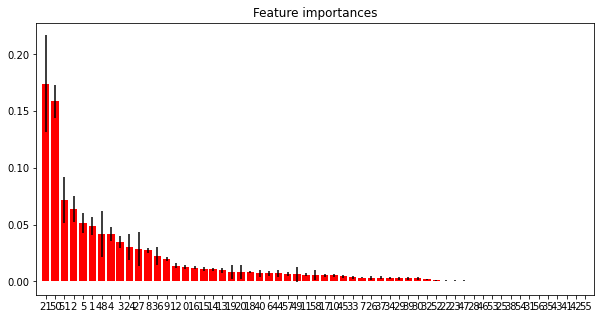

In [ ]:
importances = forest.feature_importances_
std = np.std( [tree.feature_importances_ for tree in forest.estimators_], axis=0 )
indices = np.argsort( importances )[::-1]

# print the feature ranking
df = pd.DataFrame()

print( 'Feature Ranking:\n' )
for i, j in zip( x_train_fselection,forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) ) 

# plot the impurity-based feature importances of the forest
plt.figure(figsize=(10,5))
plt.title( 'Feature importances' )
plt.bar( range( x_train_fselection.shape[1] ), importances[indices], color='r', yerr=std[indices], align='center' )
plt.xticks( range(x_train_fselection.shape[1]), indices )
plt.xlim( [-1, x_train_fselection.shape[1]] )
plt.show()

## 6.2. Boruta Selection

In [ ]:
df6.columns

Index(['id', 'num_fotos', 'marca', 'modelo', 'ano_de_fabricacao', 'ano_modelo',
       'odometro', 'num_portas', 'blindado', 'cidade_vendedor',
       'estado_vendedor', 'entrega_delivery', 'troca',
       'attr_veiculo_aceita_troca', 'attr_veiculo_unico_dono',
       'attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fabrica',
       'attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro', 'preco',
       'ano_de_fabricacao_2011', 'ano_modelo_2011', 'motor',
       'cambio_Automatizada', 'cambio_Automatizada DCT', 'cambio_Automática',
       'cambio_Automática Sequencial', 'cambio_CVT', 'cambio_Manual',
       'cambio_Semi-automática', 'tipo_vendedor_PF', 'tipo_vendedor_PJ',
       'tipo_anuncio_Acessórios e serviços para autos',
       'tipo_anuncio_Concessionária', 'tipo_anuncio_Loja',
       'tipo_anuncio_Pessoa Física', 'cor_Azul', 'cor_Branco', 'cor_Cinza',
       'cor_Dour

## 6.1. Manual Selection

In [ ]:
#cols=['preco','motor','tipo_Utilitário esportivo','odometro','modelo','km','tipo_Picape','marca','cambio_Manual','ano_modelo','ano_de_fabricacao','cidade_vendedor','cor_Branco','estado_vendedor','attr_veiculo_aceita_troca','cambio_Automática','num_fotos','attr_veiculo_licenciado','attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria','attr_veiculo_ipva_pago','attr_veiculo_unico_dono','tipo_Cupê','ano_de_fabricacao_2011','tipo_Sedã','ano_modelo_2011','attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro','cor_Preto']
cols=['preco','motor','tipo_Utilitário esportivo','km_0_40000','modelo','odometro','marca','ano_modelo','tipo_Picape','ano_de_fabricacao','cidade_vendedor','cambio_Automática']

# 7.0. MACHINE LEARNING MODELLING

In [ ]:
df7 = df6[cols].copy()
df7['preco'] = np.log1p(df7['preco'])

In [ ]:
X = df7.drop(columns=["preco"])
Y = df7['preco'].copy()

X_train, X_val, y_train, y_val = ms.train_test_split( X, Y, test_size=0.2, random_state=42 )

## 7.1. Linear Regression

In [ ]:
# model training
lr = LinearRegression().fit( X_train, y_train )

# prediction
yhat_lr = lr.predict( X_val )

# performance (error)
lr_results = ml_error( 'Linear Regression', y_val , yhat_lr )
lr_results

,Model name,MAE,MAPE,RMSE
0,Linear Regression,0.317943,0.027396,0.402969


### 7.1.1. Cross Validation

## 7.2. LASSO

### 7.2.1. Cross Validation

## 7.3. Random Forest Regressor

In [ ]:
# model
rf = RandomForestRegressor( n_estimators=150, n_jobs=-1, random_state=42 ).fit( X_train, y_train )

# prediction
yhat_rf = rf.predict( X_val )

# performance
rf_results = ml_error( 'Random Forest Regressor',np.expm1(y_val),np.expm1(yhat_rf) )
rf_results

,Model name,MAE,MAPE,RMSE
0,Random Forest Regressor,28774.928592,0.230011,47678.65835


### 7.3.1. Cross Validation

## 7.4. Decision Tree Regressor

### 7.4.1. Cross Validation

## 7.5. XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor( n_estimators=400 ).fit( X_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( X_val )

# performance
model_xgb_results = ml_error( 'XGBoost Regressor', np.expm1(y_val),np.expm1(yhat_xgb) )
model_xgb_results

,Model name,MAE,MAPE,RMSE
0,XGBoost Regressor,28131.429941,0.22269,46648.49674


### 7.5.1. Cross Validation

## 7.6. LightGBM

In [ ]:
# model
model_lgb = lgb.LGBMRegressor( n_estimators=400).fit( X_train, y_train )

# prediction
yhat_lgb = model_lgb.predict( X_val )

# performance
model_lgb_results = ml_error( 'LightGBM Regressor', np.expm1(y_val), np.expm1(yhat_lgb) )
model_lgb_results

,Model name,MAE,MAPE,RMSE
0,LightGBM Regressor,27469.646109,0.216864,46538.485027


### 7.6.1. Cross Validation

In [ ]:
from sklearn.model_selection import KFold, cross_val_score

In [ ]:
kf=KFold(n_splits=5,shuffle=True,random_state=42)

cv_result = cross_val_score(model_lgb,X,np.expm1(Y),cv=kf.split(X),scoring='neg_mean_absolute_error')*-1
np.mean(cv_result)

27984.079099926952

# 8.0. COMPARING MODELS PERFORMANCE

## 8.1. Perfomance

## 8.2. Cross Validation Performance

# 9.0. FINE TUNING

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param={'max_bin':[150,200,250],
        'num_leaves':[20,25,30],
        'min_sum_hessian_in_leaf':[0.01,0.1],
        'min_data_in_leaf':[10,15,20],
        #'bagging_fraction':[1,2],
        #'bagging_freq':[1,2],
        'feature_fraction':[0.8,0.4]}

pre_param={'max_bin':[150,200,250]}

kf=KFold(n_splits=5,shuffle=True,random_state=42)

In [ ]:
gs = GridSearchCV(model_lgb, param_grid=param, cv=kf.split(X), scoring='neg_mean_absolute_error')
gs.fit(X,np.expm1(Y))

maet = mean_absolute_error(np.expm1(y_train), gs.predict(X_train))
mae = mean_absolute_error(np.expm1(y_val), gs.predict(X_val))

print(f'MAE train set: {maet}, MAE test set: {mae}')

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.01, min_child_weight=0.001 will be ignored. Current 

In [ ]:
gs.best_params_

{'feature_fraction': 0.8,
 'max_bin': 200,
 'min_data_in_leaf': 10,
 'min_sum_hessian_in_leaf': 0.01,
 'num_leaves': 30}

### Bayeasian

In [ ]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.callbacks import CheckpointSaver

# Search space for hyper parameters
search_space = [Integer( 100, 1500, name = 'n_estimators'), 
                Integer(1, 20, name = 'max_depth'), 
                Real(0.001, 0.1, 'log-uniform', name = 'learning_rate'),
                Integer(2, 128, name = 'num_leaves'),
                Integer(1, 100, name = 'min_child_samples'),
                Real(0.05, 1.0, name = 'subsample'),
                Real(0.15, 1.0, name = 'colsample_bytree')]

# model definition
lgbm_model = lgb.LGBMRegressor(n_jobs=-1, random_state=42, subsample_freq=1)

# applying cross-validation into tunning
@use_named_args(search_space)
def model_eval( **params ):
	
    lgbm_model.set_params(**params)
    print(lgbm_model)
    kf = KFold(n_splits=10, random_state=42, shuffle=True)  
    ft_result = cross_val_score(lgbm_model, X, np.expm1(Y), scoring='neg_mean_absolute_error', cv=kf.split(X), n_jobs=-1, verbose=1)*-1
    return np.mean(ft_result)

# create checkpoints
checkpoint_callback = CheckpointSaver('lgbm_ft.pkl')

# return results and run bayesian optimize
result = gp_minimize( model_eval, search_space, n_calls = 30, 
                      n_initial_points = 10, verbose=True, n_jobs=-1, 
                      random_state= 42, callback=[checkpoint_callback])

ModuleNotFoundError: No module named 'skopt'

In [ ]:
# check best parameters

result.x

# 10.0. PRODUCTION

In [ ]:
def transform(df00):
    df01=df00.copy()
    df01.columns=['id', 'num_fotos', 'marca', 'modelo', 'versao', 'ano_de_fabricacao',
       'ano_modelo', 'odometro', 'cambio', 'num_portas', 'tipo', 'blindado',
       'cor', 'tipo_vendedor', 'cidade_vendedor', 'estado_vendedor',
       'tipo_anuncio', 'entrega_delivery', 'troca', 'elegivel_revisao',
       'attr_veiculo_aceita_troca', 'attr_veiculo_unico_dono',
       'attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria',
       'attr_veiculo_ipva_pago', 'attr_veiculo_licenciado',
       'attr_veiculo_garantia_de_fabrica',
       'attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro',
       'attr_veiculo_alienado']



    df01['num_fotos']=df01['num_fotos'].fillna(0)
    df01['attr_veiculo_aceita_troca'] = df01['attr_veiculo_aceita_troca'].apply(lambda x: 1 if x=='Aceita troca' else 0)
    df01['attr_veiculo_unico_dono'] = df01['attr_veiculo_unico_dono'].apply(lambda x: 1 if x=='Único dono' else 0)
    df01['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'] = df01['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'].apply(lambda x: 1 if x=='Todas as revisões feitas pela concessionária' else 0)
    df01['attr_veiculo_ipva_pago'] = df01['attr_veiculo_ipva_pago'].apply(lambda x: 1 if x=='IPVA pago' else 0)
    df01['attr_veiculo_licenciado'] = df01['attr_veiculo_licenciado'].apply(lambda x: 1 if x=='Licenciado' else 0)
    df01['attr_veiculo_garantia_de_fabrica'] = df01['attr_veiculo_garantia_de_fabrica'].apply(lambda x: 1 if x=='Garantia de fábrica' else 0)
    df01['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro'] = df01['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro'].apply(lambda x: 1 if x=='Todas as revisões feitas pela agenda do carro' else 0)




    df01['num_fotos']=df01['num_fotos'].astype('int64')
    df01['ano_modelo']=df01['ano_modelo'].astype('int64')
    df01['odometro']=df01['odometro'].astype('int64')
    df01['attr_veiculo_aceita_troca']=df01['attr_veiculo_aceita_troca'].astype('int64')
    df01['attr_veiculo_unico_dono']=df01['attr_veiculo_unico_dono'].astype('int64')
    df01['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria']=df01['attr_veiculo_todas_as_revisoes_feitas_pela_concessionaria'].astype('int64')
    df01['attr_veiculo_ipva_pago']=df01['attr_veiculo_ipva_pago'].astype('int64')
    df01['attr_veiculo_licenciado']=df01['attr_veiculo_licenciado'].astype('int64')
    df01['attr_veiculo_garantia_de_fabrica']=df01['attr_veiculo_garantia_de_fabrica'].astype('int64')
    df01['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro']=df01['attr_veiculo_todas_as_revisoes_feitas_pela_agenda_do_carro'].astype('int64')
    df01['attr_veiculo_alienado']=df01['attr_veiculo_alienado'].astype(str)


    df02=df01.copy()

    # ano de fabricação
    df02['ano_de_fabricacao_2011']=df02['ano_de_fabricacao'].apply(lambda x: 1 if x>2010 else 0)
    # ano_modelo
    df02['ano_modelo_2011']=df02['ano_de_fabricacao'].apply(lambda x: 1 if x>2010 else 0)
    # kilometragem 100 - 400000
    df02['km']=df02['odometro'].apply(lambda x: '0_40000' if x<=40000 else
                                                '40000_80000'if x<=80000 else
                                                '80000_120000' if x<=120000  else
                                                '120000_160000' if x<=160000  else
                                                '160000_200000' if x<=200000  else
                                                '200000_240000' if x<=240000  else
                                                '240000_280000' if x<=280000  else
                                                '280000_320000' if x<=320000  else
                                                '320000_360000' if x<=360000  else
                                                '360000_400000')
    # motor
    df02['motor_3_chr']=df02['versao'].apply(lambda x: x[0:3])
    df02['motor_num']=df02['motor_3_chr'].apply(lambda x: x[0:1].isnumeric())
    df02['motor_ponto']=df02['motor_3_chr'].apply(lambda x: x[1:2]=='.')
    df02['motor']=df02[['motor_num','motor_ponto','motor_3_chr']].apply(lambda x: x['motor_3_chr'] if (x['motor_num']==True)&(x['motor_ponto']==True) else 0,axis=1)
    df02['motor']=df02['motor'].astype('float64')

    df03=df02.copy()


    df03 = df03.drop( columns=['elegivel_revisao','attr_veiculo_alienado', 'motor_3_chr', 'motor_num', 'motor_ponto','versao'])


    df05=df03.copy()

    #labelencoding
    le = LabelEncoder()
    df05['modelo'] = le.fit_transform(df05['modelo'])
    #df05['km']=le.fit_transform(df05['km'])
    df05['blindado'] = df05['blindado'].apply( lambda x: 1 if x == "S" else 0 )
    df05['troca'] = df05['troca'].apply( lambda x: 1 if x == True else 0)
    df05['entrega_delivery'] = df05['entrega_delivery'].apply( lambda x: 1 if x == True else 0)

    # dummies
    df05 = pd.get_dummies( df05, columns=['cambio','tipo_vendedor','tipo_anuncio', 'cor','tipo','km'] )

    #frequency encoder
    fe_modelo = df05.groupby('modelo').size() / len(df05)
    df05.loc[:,'modelo'] = df05['modelo'].map(fe_modelo)
    fe_marca = df05.groupby('marca').size() / len(df05)
    df05.loc[:,'marca'] = df05['marca'].map(fe_marca)
    fe_cidade_vendedor = df05.groupby('cidade_vendedor').size() / len(df05)
    df05.loc[:,'cidade_vendedor'] = df05['cidade_vendedor'].map(fe_cidade_vendedor)

    df05['estado_vendedor']=df05['estado_vendedor'].apply(lambda x: 'SP' if x=='São Paulo (SP)' else 
                                                            'RS' if x=='Rio Grande do Sul (RS)' else 
                                                            'MG' if x=='Minas Gerais (MG)' else
                                                            'PR' if x=='Paraná (PR)' else
                                                            'RJ' if x=='Rio de Janeiro (RJ)' else
                                                            'MA' if x=='Maranhão (MA)' else
                                                            'SC' if x=='Santa Catarina (SC)' else
                                                            'AL' if x=='Alagoas (AL)' else
                                                            'BA' if x=='Bahia (BA)' else
                                                            'GO' if x=='Goiás (GO)' else
                                                            'RN' if x=='Rio Grande do Norte (RN)' else
                                                            'PE' if x=='Pernambuco (PE)' else
                                                            'MT' if x=='Mato Grosso (MT)' else
                                                            'PA' if x=='Pará (PA)' else
                                                            'CE' if x=='Ceará (CE)' else
                                                            'AM' if x=='Amazonas (AM)' else
                                                            'ES' if x=='Espírito Santo (ES)'else
                                                            'RO' if x=='Rondônia (RO)' else
                                                            'PB' if x=='Paraíba (PB)' else
                                                            'TO' if x=='Tocantins (TO)' else
                                                            'AC' if x=='Acre (AC)'else
                                                            'SE' if x=='Sergipe (SE)' else
                                                            'MS' if x=='Mato Grosso do Sul (MS)' else
                                                            'RR' if x=='Roraima (RR)'else
                                                            'PI' if x=='Piauí (PI)' else 0)

    fe_estado_vendedor = df05.groupby('estado_vendedor').size() / len(df05)
    df05.loc[:,'estado_vendedor'] = df05['estado_vendedor'].map(fe_estado_vendedor)




    rs = RobustScaler()
    mms = MinMaxScaler()

    df05['num_fotos'] = mms.fit_transform(df05[['num_fotos']].values)
    df05['ano_de_fabricacao'] = rs.fit_transform(df05[['ano_de_fabricacao']].values)
    df05['ano_modelo'] = rs.fit_transform(df05[['ano_modelo']].values)
    df05['odometro'] = rs.fit_transform(df05[['odometro']].values)
    
    cols=['motor','tipo_Utilitário esportivo','km_0_40000','modelo','odometro','marca','ano_modelo','tipo_Picape','ano_de_fabricacao','cidade_vendedor','cambio_Automática']
    return df05[cols]

X_test = transform(df_test)

Full_X_train = pd.concat([X_train, X_val], axis=0)
Full_Y_train = pd.concat([y_train, y_val], axis=0)

# model
model_lgb = lgb.LGBMRegressor(n_estimators=400).fit( Full_X_train, Full_Y_train )

# prediction
preco = model_lgb.predict( X_test )

# performance
df_test['preco'] = np.expm1(preco)
Submission = df_test[['ID','preco']]

In [ ]:
Submission.to_csv('Submission_4.csv',index=False)

In [ ]:
Full_X_train = pd.concat([X_train, X_val], axis=0)
Full_Y_train = pd.concat([y_train, y_val], axis=0)

# model
model_lgb = lgb.LGBMRegressor(n_estimators=400).fit( Full_X_train, Full_Y_train )

# prediction
preco = rf.predict( X_test )

# performance
df_test['preco'] = preco
Submission = df_test[['ID','preco']]

In [ ]:
Submission.to_csv( 'Submission_3.csv', index=False )

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3039c7b4-bcc6-4ef2-8633-383a22ac2c90' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>